In [41]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import datasets , models, transforms
from urllib import *
url = './data'

In [42]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [70]:
transform = transforms.Compose([transforms.Resize((28,28)), transforms.ToTensor(), transforms.Normalize((0.5,) , (0.5,))])
training_dataset = datasets.MNIST(root = './data', train = True , download = True , transform = transform)
validation_dataset = datasets.MNIST(root = './data' , train = False , download = True , transform = transform)

training_loader = torch.utils.data.DataLoader(training_dataset, batch_size = 100, shuffle = True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size = 100 , shuffle = False)

training_dataset
validation_dataset

Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               Resize(size=(32, 32), interpolation=PIL.Image.BILINEAR)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

In [67]:
def im_convert(tensor):
    image = tensor.clone().detach().numpy()
    image = image.transpose(1, 2, 0)
    image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5)) #for 28,28,1
    image = image.clip(0,1)
    return image

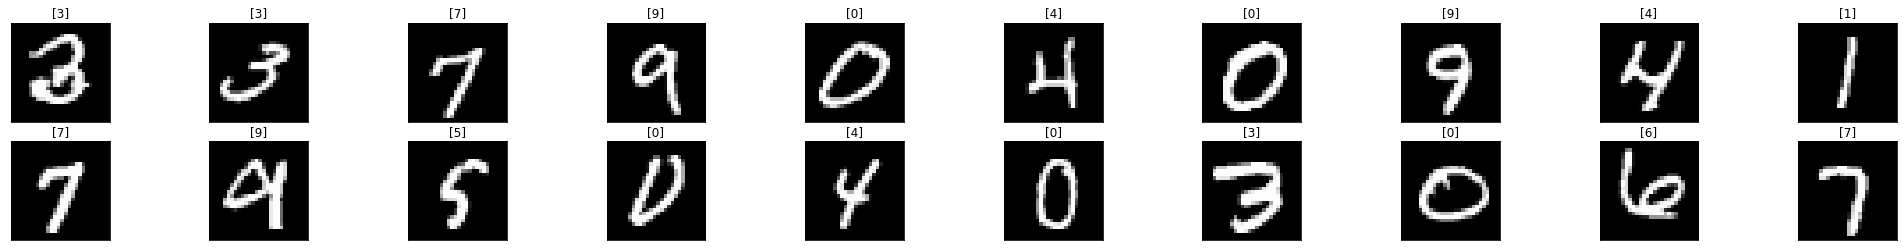

In [45]:
dataiter = iter(training_loader) #make sure you are using training loader not training dataset
images , labels = dataiter.next()
images = images.to(device)
labels = labels.to(device)
fig = plt.figure(figsize=(35,4))

for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[] , yticks= [])
    plt.imshow(im_convert(images[idx]))
    ax.set_title([labels[idx].item()])

In [46]:
class LeNet(nn.Module):
    def __init__(self): #convolution doesnt need input or output size
        super().__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1 )#input channels, output size which is also number of channels in next layer, kernel size, stride
        #larger stride -> less effective feature extraction
        #small pictures -> small strides are better
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500) #precedig layer had 50 outputs #4*4 is obtainable  #500 = out put
        self.dropout1 = nn.Dropout(0.5) #we put dropout between two layers which have more nodes #0.5 is droping propability
        self.fc2 = nn.Linear(500, 10)
#be aware that pollin is not archtecture but it is for training
    def forward(self , x):
        x = F.relu(self.conv1(x)) #assingning relu for output of conv1
        x = F.max_pool2d(x, 2, 2) #2 , 2 is for halfing them
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50 )#flatting x for going to fully connected layers #columns=-1 so network will decide for it, rows
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = self.fc2(x) #last layer doesnt need relu
        return x
        

In [47]:
model = LeNet().to(device) #GPU
model

LeNet(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=800, out_features=500, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)

In [48]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters() , lr = 0.0001)#make sure lr is small enough

In [49]:
epochs = 10
train_loss_history = []
train_correct_history = []
validation_loss_history = []
validation_correct_history = []


for e in range(epochs):
    
    train_running_loss = 0.0
    train_running_correct = 0.0
    validation_running_loss = 0.0
    validation_running_correct = 0.0
    
    
    for inputs , labels in training_loader:
        inputs = inputs.to(device) #GPU
        labels = labels.to(device)
        
        outputs = model(inputs) #train
        
        loss = criterion(outputs, labels)#loss calculation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        _, preds = torch.max(outputs, 1) #classify
        
        train_running_loss += loss.item() #all losses in 1 epoch
        train_running_correct += torch.sum(preds == labels.data)
        
    else:
        with torch.no_grad():
            for validation_inputs, validation_labels in validation_loader:
                validation_inputs = validation_inputs.to(device)
                validation_labels = validation_labels.to(device)
                
                validation_outputs = model(validation_inputs)
                
                validation_loss = criterion(validation_outputs, validation_labels)
                _, validation_preds = torch.max(validation_outputs, 1)
                
                validation_running_loss += validation_loss.item()
                validation_running_correct += torch.sum(validation_preds == validation_labels.data)
                
        training_epoch_loss = train_running_loss/len(training_loader)
        training_epoch_correct = train_running_correct.float()/len(training_loader.dataset)
        validation_epoch_loss = validation_running_loss/len(validation_loader)
        validation_epoch_correct = validation_running_correct.float()/len(validation_loader.dataset)
        
        train_loss_history.append(training_epoch_loss)
        train_correct_history.append(training_epoch_correct)
        validation_loss_history.append(validation_epoch_loss)
        validation_correct_history.append(validation_epoch_correct)
        
        print("epoch: ",(e+1))
        print("training loss = {:.4f}  training accuracy {:.4f} ".format(training_epoch_loss, training_epoch_correct))
        print("validation loss = {:.4f} validation accuracy {:.4f}".format(validation_epoch_loss , validation_epoch_correct))
        print("==============================================================================")
        
                

epoch:  1
training loss = 0.0062  training accuracy 0.8306 
validation loss = 0.0021 validation accuracy 0.9386
epoch:  2
training loss = 0.0017  training accuracy 0.9512 
validation loss = 0.0012 validation accuracy 0.9649
epoch:  3
training loss = 0.0011  training accuracy 0.9671 
validation loss = 0.0009 validation accuracy 0.9730
epoch:  4
training loss = 0.0009  training accuracy 0.9743 
validation loss = 0.0007 validation accuracy 0.9810
epoch:  5
training loss = 0.0007  training accuracy 0.9787 
validation loss = 0.0005 validation accuracy 0.9832
epoch:  6
training loss = 0.0006  training accuracy 0.9810 
validation loss = 0.0005 validation accuracy 0.9841
epoch:  7
training loss = 0.0005  training accuracy 0.9833 
validation loss = 0.0005 validation accuracy 0.9854
epoch:  8
training loss = 0.0005  training accuracy 0.9858 
validation loss = 0.0004 validation accuracy 0.9854
epoch:  9
training loss = 0.0004  training accuracy 0.9867 
validation loss = 0.0004 validation accuracy

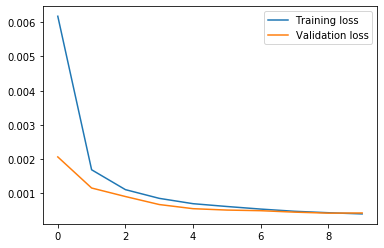

In [50]:
plt.plot(train_loss_history, label = 'Training loss')
plt.plot(validation_loss_history, label = 'Validation loss')
plt.legend() #to view both lines seprately

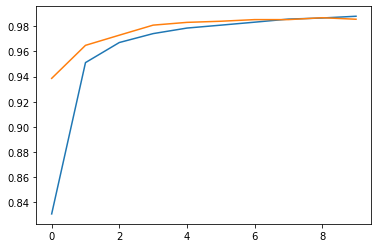

In [51]:
plt.plot(train_correct_history, label = 'Train accuracy')
plt.plot(validation_correct_history, label = 'Validation accuracy')

In [52]:
#test

import PIL.ImageOps
import requests
from PIL import Image

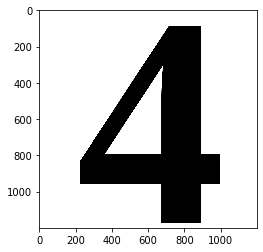

In [61]:
url1 = 'https://upload.wikimedia.org/wikipedia/commons/thumb/e/e4/Quatre.svg/1200px-Quatre.svg.png'
response = requests.get(url1, stream = True)
img = Image.open(response.raw)
plt.imshow(img)

#for doing this you need internet connection

In [2]:
#making any picture compatible with our model pictures

#img = PIL.ImageOps.invert(img)
#img = img.convert('1')
#img = transform(img) 
#plt.imshow(im_convert(img))

In [65]:
#images = img.to(device)
#print(images[0].unsqueeze(0).unsqueeze(0)) #dimension 1
#image = images[0].unsqueeze(0).unsqueeze(0)
#output = model(image)
#_, pred = torch.max(output, 1)
#print(pred.item())

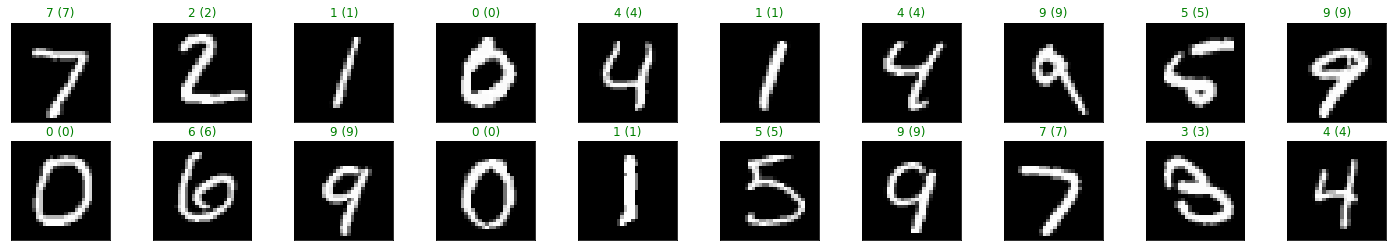

In [69]:
#test

dataiter = iter(validation_loader)
images, labels = dataiter.next()
images = images.to(device)
labels = labels.to(device)
#images_ = images.view(images.shape[0], -1) we dont need because CNN supports 3 dimensional
output = model(images)
_, preds = torch.max(output, 1)
fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    plt.imshow(im_convert(images[idx]))
    ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())), color=("green" if preds[idx]==labels[idx] else "red"))